<a href="https://colab.research.google.com/github/rahultheogre/TransplantWaitTimePrediction/blob/main/Transplant_Wait_time_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABOUT THE DATASET

##### Source
https://www.kaggle.com/datasets/gustavomodelli/waitlist-kidney-brazil (The data consist of patients registered, between January 1, 2000 and December 31, 2017, in the waiting list of São Paulo State Organ Allocation System (SP-OAS) /Brazil.)

##### Context
Predicting waiting time for a deceased donor kidney transplant can help patients and clinicians to discuss management and contribute to a more efficient use of resources

##### Content
A model was developed with this data and published in PlosOne. We expect to improve upon that model.

##### Reference: 
Sapiertein Silva JF, Ferreira GF, Perosa M, Nga HS, de Andrade LGM. A machine learning prediction model for waiting time to kidney transplant. PLoS One. 2021 May 20;16(5):e0252069. doi: 10.1371/journal.pone.0252069. PMID: 34015020. (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252069)

##### Allocation criteria
Allocation was performed as established by the National Transplantation System of the Brazilian Ministry of Health. For deceased donor transplants, allocation criteria are based on HLA matching (highest number of points for HLA DR, followed by HLA B and HLA A), recipient's age (<18 years), date of registration on the waiting list, and panel reactive antibody (PRA). A point score system based on blood group and HLA match is used as follows:

DR: 0 MM = 10 points; 1 MM = 5 points; 2 MM = 0 point;
B: 0 MM = 4 points; 1 MM = 2 points; 2 MM = 0 point;
A: 0 MM = 1 point; 1 MM = 0.5 point; 2 MM = 0 point.

Waiting time, allosensitization (cPRA >50), diabetes mellitus, and age < 18 years served as tiebreakers.

# DATA AUDITING

In [ ]:
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.3 MB/s 
     |████████████████████████████████| 68 kB 5.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=c6be69f26b2ad2c2eb8cddd499480a604220ac04f802f3a8d21d458d1f902926
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.

In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.5f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importin seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
#Survival Analysis
from lifelines import KaplanMeierFitter,CoxPHFitter
#---------------------------------------------------------------------

import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, MinMaxScaler  

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## PRELIMINARY OBSERVATIONS

In [ ]:
#reading the file
data = pd.read_csv('https://raw.githubusercontent.com/rahultheogre/datasets/main/BYOP/waitlist.csv', encoding='latin-1')

In [ ]:
#checking 15 random samples to have an idea of the data
data.sample(15)

,Id,date,age_at_list_registration,age_cat,time_on_Dialysis,race,sex,underline_disease,diabetes,Blood_type,number_transfusion,gestation,number_gestation,prior_transplant,number_prior_transplant,subregion,cPRA,cPRA_cat,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,DR_00,B_00,A_00,calculated_frequency_DR.f1,calculated_frequency_DR.f2,calculated_frequency_DR.f,calculated_frequency_B.f1,calculated_frequency_B.f2,calculated_frequency_B.f,calculated_frequency_A.f1,calculated_frequency_A.f2,calculated_frequency_A.f,chagas,anti.HBc,anti.HCV,agHBs,patient_still_on_list,date_acutal,death,Time_death,Transplant,Transplant_Y_N,X36MthsTx,Time_Tx,priorization,removed_list,razon_removed,time,event
243,322,2007-10-03,42,18.a.60,56.00000,Branca,M,GNC,1,A,0,Não,NaN,Sim,2,FUNDERP,0,Zero,1,30,8,58,3,13,heterozigoto,heterozigoto,heterozigoto,0.18000,0.25000,4.50000,0.08000,0.07000,0.56000,0.17000,0.13000,2.21000,Não,Não,Não,Não,Não,43307,Não,132,Sim,Sim,0,63.83000,Não,Não,NaN,1915,1
35348,42523,2015-02-19,46,18.a.60,6.00000,Branca,M,Outras,1,B,0,Não,NaN,Não,0,UNIFESP,0,Zero,26,33,14,51,1,13,heterozigoto,heterozigoto,heterozigoto,0.19000,0.25000,4.75000,0.10000,0.14000,1.40000,0.06000,0.07000,0.42000,Não,Não,Não,Não,Não,43307,Sim,17,Sim,Sim,1,0.57000,Não,Não,NaN,17,1
27502,33796,2017-06-23,34,18.a.60,23.00000,Parda,F,HAS,1,O,3,Sim,2.00000,Não,0,UNIFESP,52,Entre_50_80,11,30,18,55,3,13,heterozigoto,heterozigoto,heterozigoto,0.18000,0.25000,4.50000,0.09000,0.03000,0.27000,0.10000,0.13000,1.30000,Não,Não,Não,Não,Sim,43307,Não,13,Não,Não,0,13.27000,Não,Não,NaN,398,0
4479,5967,2010-01-20,58,18.a.60,72.00000,Branca,M,HAS,1,A,0,Não,NaN,Não,0,UNIFESP,95,Maior_80,2,11,49,52,4,15,heterozigoto,heterozigoto,heterozigoto,0.23000,0.21000,4.83000,0.05000,0.04000,0.20000,0.42000,0.10000,4.20000,Não,Não,Não,Não,Não,43307,Não,104,Não,Não,0,18.17000,Não,Sim,Removido (suspenso > 365 dias),545,3
46343,54894,2010-02-26,41,18.a.60,19.00000,Branca,F,Outras,1,O,1,Sim,2.00000,Não,0,UNIFESP,71,Entre_50_80,29,30,42,44,3,12,heterozigoto,heterozigoto,heterozigoto,0.18000,0.04000,0.72000,0.04000,0.20000,0.80000,0.08000,0.13000,1.04000,Não,Não,Não,Não,Sim,43307,Não,102,Não,Não,0,102.40000,Não,Não,NaN,3072,0
37353,44750,2003-01-13,56,18.a.60,4.00000,Branca,M,Diabetes,0,A,0,Não,NaN,Não,0,UNIFESP,0,Zero,0,1,8,51,3,11,heterozigoto,heterozigoto,homozigoto,0.18000,0.23000,4.14000,0.08000,0.14000,1.12000,0.00000,0.17000,0.00000,Não,Não,Não,Não,Não,43307,Não,189,Não,Não,0,36.93000,Não,Sim,Removido (suspenso > 365 dias),1108,3
47109,55769,2003-01-18,66,Maior.60,6.00000,Branca,M,HAS,1,O,0,Não,NaN,Não,0,UNICAMP,0,Zero,23,33,0,7,11,15,heterozigoto,homozigoto,heterozigoto,0.23000,0.21000,4.83000,0.00000,0.14000,0.00000,0.11000,0.07000,0.77000,Não,Não,Não,Não,Não,43307,Não,189,Não,Não,0,75.37000,Não,Sim,Removido (suspenso > 365 dias),2261,3
2643,3550,2016-10-05,32,18.a.60,10.00000,Branca,F,Outras,1,A,1,Não,0.00000,Não,0,UNIFESP,0,Zero,3,11,7,35,11,0,homozigoto,heterozigoto,heterozigoto,0.23000,0.00000,0.00000,0.14000,0.21000,2.94000,0.18000,0.10000,1.80000,Não,Não,Não,Não,Sim,43307,Não,22,Não,Não,0,21.97000,Não,Não,NaN,659,0
30732,37422,2006-07-31,56,18.a.60,5.00000,Branca,F,HAS,1,A,0,Não,0.00000,Não,0,FUNDERP,0,Zero,3,25,18,44,1,13,heterozigoto,heterozigoto,heterozigoto,0.19000,0.25000,4.75000,0.09000,0.20000,1.80000,0.18000,0.02000,0.36000,Não,Não,Não,Não,Não,43307,Não,146,Sim,Sim,1,13.03000,Não,Não,NaN,391,1
16833,21886,2014-10-21,25,18.a.60,9.00000,Negra,M,HAS,1,O,0,Não,NaN,Não,0,UNICAMP,0,Zero,2,11,40,40,13,16,heterozigoto,heterozigoto,heterozigoto,0.25000,0.07000,1.75000,0.09000,0.09000,0.81000,0.42000,0.10000,4.20000,Não,Não,Não,Não,Não,43307,Não,46,Sim,Sim,1,7.83000,Não,Não,NaN,235,1


- Portuguese language is used, as expected, as the data is from Brazil.
- We will replace portuguese words with english when needed. Doing it right now will be computationally expensive.
- anti.HBc, anti.HCV etc are a few feature names that might be problematic because of the dot. We would be prefer to replace . with _. 
- the dataset looks consistent. But we will check it feature by feature as they too many of them. We will also take actions if needed, on the spot.

### Replacing a few portuguese words by their English equivalent

In [ ]:
data.replace(to_replace= 'Não' , value= 'NO', inplace=True)
data.replace(to_replace= 'Sim' , value= 'YES', inplace=True)

### Renaming problematic features

In [ ]:
data.rename(columns = {'anti.HBc':'HBc_antibodies', 'anti.HCV':'HCV_antibodies'}, inplace=True)

- Let's explore with basic info.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          48153 non-null  int64  
 1   date                        48153 non-null  object 
 2   age_at_list_registration    48153 non-null  int64  
 3   age_cat                     48153 non-null  object 
 4   time_on_Dialysis            46817 non-null  float64
 5   race                        48153 non-null  object 
 6   sex                         48153 non-null  object 
 7   underline_disease           48153 non-null  object 
 8   diabetes                    48153 non-null  int64  
 9   Blood_type                  48153 non-null  object 
 10  number_transfusion          48153 non-null  int64  
 11  gestation                   48153 non-null  object 
 12  number_gestation            19464 non-null  float64
 13  prior_transplant            481

- 12 float; 17 int; and 24 object variables
- 48153 tuples/rows and 53 features
- many null values that we will impute case by case
- predicted variables: time/Time_Tx and event
- date should be converted into datetime format for processing
- an indepth research into features, considering their business value, has to be performed.

Converting the 'date' feature from string to datetime format

In [ ]:
data['date']= pd.to_datetime(data['date'])

# NEED FOR SURVIVAL ANALYSIS METHODS

- in survival analysis methods, we first classify on the basis of E), and then we regress on the basis of T(duration)
- censored subset is that subset of dataset which leaves out its effect on the outcomes midway
- - in survival analysis, we try to take as much information as we can from the censored data

In [ ]:
 #defining two constants for 
 # t=beginning of study = 0
 # t=end of study = T
 
 start_date = pd.to_datetime('2000-01-01') #beginning of study
 end_date = pd.to_datetime('2017-12-31') #end of study

In [ ]:
#checking presence of any left censored data
data.loc[data['date'] < start_date].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Id                           0.00000
age_at_list_registration     0.00000
age_cat                      0.00000
time_on_Dialysis             0.00000
race                         0.00000
sex                          0.00000
underline_disease            0.00000
diabetes                     0.00000
Blood_type                   0.00000
number_transfusion           0.00000
gestation                    0.00000
number_gestation             0.00000
prior_transplant             0.00000
number_prior_transplant      0.00000
subregion                    0.00000
cPRA                         0.00000
cPRA_cat                     0.00000
HLA_A1                       0.00000
HLA_A2                       0.00000
HLA_B1                       0.00000
HLA_B2                       0.00000
HLA_DR1                      0.00000
HLA_DR2                      0.00000
DR_00                        0.00000
B_00                         0.00000
A_00                         0.00000
calculated_frequency_DR.f1   0.00000
c


- We have no patient registered before when the study began. 
- No left censored data.
- So we can go ahead with CPH

# TREATMENT OF DUPLICATE VALUES

In [ ]:
#checking presence of duplicates
data.duplicated().sum()

0

- No duplicate values
- No treatment required


# TREATMENT OF MISSING VALUES

In [ ]:
# getting percentage of missing values per feature
data.isna().sum()/len(data)*100

Id                            0.00000
date                          0.00000
age_at_list_registration      0.00000
age_cat                       0.00000
time_on_Dialysis              2.77449
race                          0.00000
sex                           0.00000
underline_disease             0.00000
diabetes                      0.00000
Blood_type                    0.00000
number_transfusion            0.00000
gestation                     0.00000
number_gestation             59.57884
prior_transplant              0.00000
number_prior_transplant       0.00000
subregion                     0.00000
cPRA                          0.00000
cPRA_cat                      0.00000
HLA_A1                        0.00000
HLA_A2                        0.00000
HLA_B1                        0.00000
HLA_B2                        0.00000
HLA_DR1                       0.00000
HLA_DR2                       0.00000
DR_00                         0.00000
B_00                          0.00000
A_00        

- time_on_Dialysis, number_gestation, chagas, agHBs, HCV_antibodies, razon_removed:: these 6 features might need 'missing value imputation' 
- Let us deal with them one by one

##### 'razon_removed'
- 'razon_removed' has 68% of its values missing. We will drop this column

In [ ]:
data = data.drop(columns=['razon_removed'])

##### number_gestation


- Around 59 percent of its values are NaN. 
- But we cannot drop this feature just like that or even replace the missing values with a mode
  - we have to consider that the data was not entered in case of Males, and hence NaN
  - Let's check

In [ ]:
data[data['sex']=='M']['number_gestation'].isna().sum()

28679

- Yes, that is exactly the case. For all 'sex' values 'M', we have 'number_gestation' as NaN. 
- We will impute NaN with 0.

In [ ]:
data['number_gestation'] = np.where(data['number_gestation'].isna(), 0 , data['number_gestation'])


##### dialysis_duration: 
- We impute with 1 because as soon as someone's kidney fails, they are necessarily put on dialysis. And since the data is of patients awaiting cadaveric graft, everyone who is one list has had at least on session of dialysis. 
- We will even replace all zeros with 1.

In [ ]:
data['time_on_Dialysis'] = np.where(data['time_on_Dialysis'].isna(), 1 , data['time_on_Dialysis'])
data['time_on_Dialysis'] = np.where(data['time_on_Dialysis'] == 0, 1 , data['time_on_Dialysis'])

##### HCV_antibodies

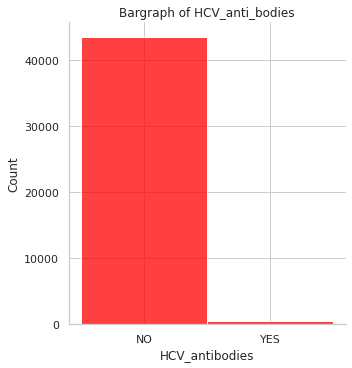

In [ ]:
sns.displot(data=data,x='HCV_antibodies',color='Red')
plt.title("Bargraph of HCV_anti_bodies")
plt.show()

- most of the values are 'NO'
- HCV_antibodies = 
  - NO, if the patient has no antibodies i.e. the patient has never been infected with HC Virus
  - YES, if the patient has antibodies i.e. the patient has been or is infected with the HCV 
- In general, we have to take for granted that people are not infected. So their HCV_antibodies value should be 'NO'.
- That we will impute all the NaN values in this feature with 'NO'.

In [ ]:
data['HCV_antibodies'] = np.where(data['HCV_antibodies'].isna(), 'NO' , data['HCV_antibodies'])

##### agHBs


In [ ]:
data['agHBs'].value_counts()

NO     44022
YES      119
Name: agHBs, dtype: int64

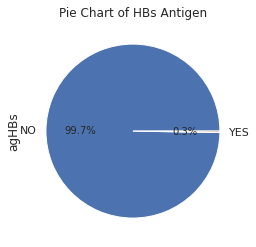

In [ ]:
data['agHBs'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Pie Chart of HBs Antigen")
plt.show()

- Of the non-NaN values, 99.7% values are 'NO'- which is the case with general population
- A "positive" ('YES') HBsAg test result means that the person is infected with hepatitis B. That is not the case, in general, in populations. Most people are Negative.
- Since almost all people in this dataset are also negative, we will drop this feature, as a singletone feature has no statistical significance.
- It would be ridiculous to impute the NaN values with 'NO' and claim some significance for the feature.

In [ ]:
# dropping agHBs
data.drop(columns=['agHBs'], inplace=True)

##### chagas

- chagas is a malaria like disease endemic to Brazil

In [ ]:
data['chagas'].value_counts()

NO     44069
YES       72
Name: chagas, dtype: int64

- Of the total 48153 patients, ONLY 72 are positive for chagas

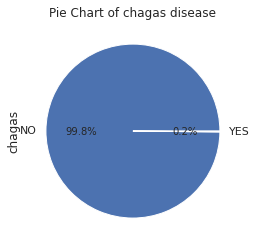

In [ ]:
data['chagas'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Pie Chart of chagas disease")
plt.show()

Clearly, we need to drop this feature

In [ ]:
data.drop(columns='chagas',inplace=True)

In [ ]:
data.isna().sum()/len(data)*100

Id                           0.00000
date                         0.00000
age_at_list_registration     0.00000
age_cat                      0.00000
time_on_Dialysis             0.00000
race                         0.00000
sex                          0.00000
underline_disease            0.00000
diabetes                     0.00000
Blood_type                   0.00000
number_transfusion           0.00000
gestation                    0.00000
number_gestation             0.00000
prior_transplant             0.00000
number_prior_transplant      0.00000
subregion                    0.00000
cPRA                         0.00000
cPRA_cat                     0.00000
HLA_A1                       0.00000
HLA_A2                       0.00000
HLA_B1                       0.00000
HLA_B2                       0.00000
HLA_DR1                      0.00000
HLA_DR2                      0.00000
DR_00                        0.00000
B_00                         0.00000
A_00                         0.00000
c

- There are no missing values in the dataset now.

# EXPLORATORY DATA ANALYSIS

#### Checking features: number_gestation and gestation

In [ ]:
from matplotlib import rcParams

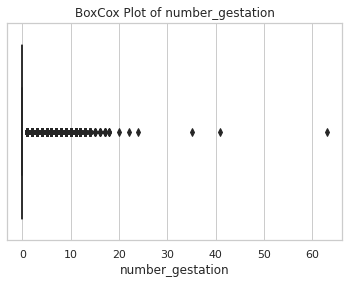

In [ ]:
#checking with boxplot
sns.boxplot(x = data['number_gestation'],orient = 'h',color='Green')
plt.title("BoxCox Plot of number_gestation")
rcParams['figure.figsize'] = 10,6
plt.show()

One extreme value (63) beyond the expected limit of 42 weeks in number_gestation. We will replace it with 42.

In [ ]:
#the outlier seems to be a result of incorrect data entry
data['number_gestation'] = data['number_gestation'].replace([63.0],42.0) 

In [ ]:
# creating an empty list of features to be removed.
# we will append new features to it as we come across them
to_be_removed = []

#### Checking features: priorization

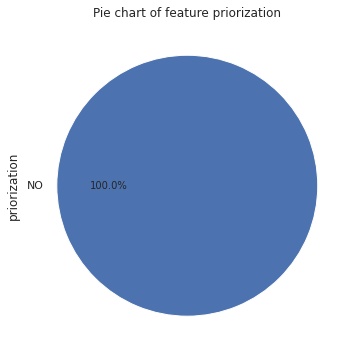

In [ ]:
data['priorization'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature priorization')
plt.show()

- ALL PRIOTIZATION VALUES WERE ALREADY REMOVED. REDUNDANT COLUMN. there is only one value 'No'. No priority was given to any of the patients.
- This feature should be removed. As it does not give us any information.

In [ ]:
to_be_removed.append('priorization')

#### Checking features: date_acutal

- Study goes from January 1, 2000 and December 31, 2017. 
- 'date_acutal' is 26-07-2018- at least 7 months after the study ended. This is the date when the reaserchers started their analysis.
- This date is of no statistical significance. Our study time period is January 1, 2000 and December 31, 2017.
- So, we will remove this feature

In [ ]:
to_be_removed.append('date_acutal')

#### Checking features: X36MthsTx

- No Idea
- even after continued discussions in the team and with doctors, we concluded that this column is redundant, and needs to be removed.

In [ ]:
to_be_removed.append('X36MthsTx')

#### Checking features: number_prior_transplant and prior_transplant

- According to our study, (from discussions with Nephrologists) what matters is if the patient had a prior transplant. The number of prior transplants is of less significance.
- the information about if the patient had a prior transplant or not is contained in the feature 'prior_transplant'
- So we will remove 'number_prior_transplant' 

In [ ]:
to_be_removed.append('number_prior_transplant')

#### Checking features: time and Time_Tx

- Let us observe time's distribution and the distribution of Time_Tx, a feature which looks suspiciously similar to it.

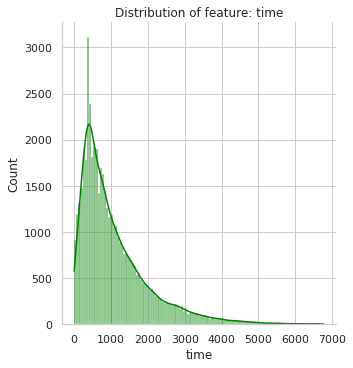

In [ ]:
sns.displot(x=data['time'],kde=True, color='Green')
plt.title('Distribution of feature: time')
plt.show()

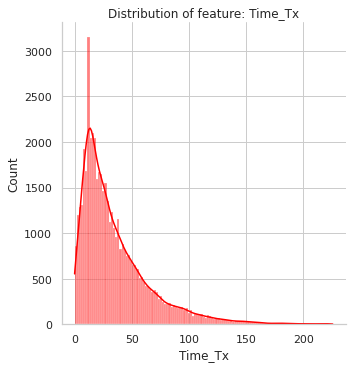

In [ ]:
sns.displot(x=data['Time_Tx'],kde=True, color='Red')
plt.title('Distribution of feature: Time_Tx')
plt.show()

- both features have EXACTLY the same distribution. Even the counts are same. Only scale metric is different.
- 'time' is in days. And 'TimeTx' is in months.
- We will choose the one with lower range.
- So we will drop 'time'

In [ ]:
to_be_removed.append('time')

#### Checking features: Transplant, Transplant_Y_N and death


- we will remove it because it contains superfluous information already contained in death and Transplant_Y_N features.
- Above conclusion is based on Business understanding of the problem
- But we will still try to prove it via statistical methods

In [ ]:
data['Transplant'].value_counts()

NO             25289
YES            13732
Óbito Lista     9132
Name: Transplant, dtype: int64

- Óbito Lista means Death List
- So let's replace this phrase with its english equivalent everywhere.

In [ ]:
data.replace(to_replace= 'Óbito Lista' , value= 'DeathList', inplace=True)

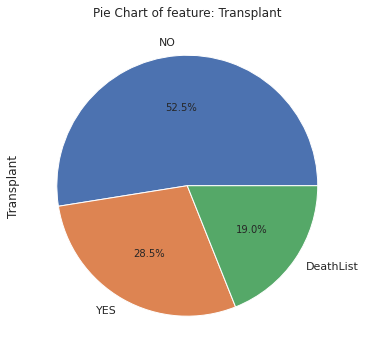

In [ ]:
data['Transplant'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie Chart of feature: Transplant')
plt.show()

- Either the transplant did not happen (52.5%), or it happened (28.5%) or the patient was put on DeathList (19%)
- There is something spurious about data representation.
- Its logical that the patient definitely didn't get to be transplanted if he was dead.
- Let us check two more pie charts: that of 'death' and 'Transplant_Y_N'

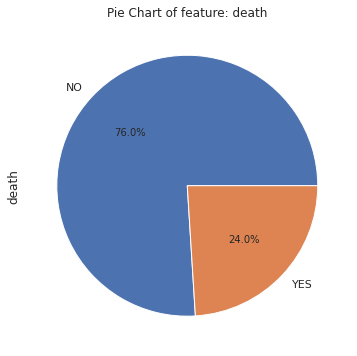

In [ ]:
data['death'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie Chart of feature: death')
plt.show()

- 24% of people died by the end of the study but 5% of them were not put on death list- which happens in many cases. Data is consistent.
- But we are not after if a particular patient died.
- We just wanted to make sure if DeathList percent in 'Transplant' is consistent. It is.

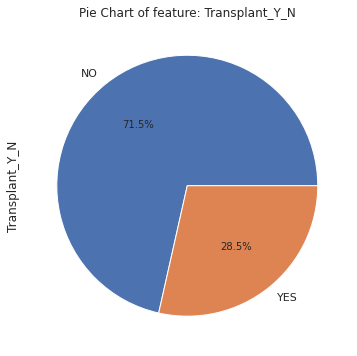

In [ ]:
data['Transplant_Y_N'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie Chart of feature: Transplant_Y_N')
plt.show()


- 28.5% patients got transplanted - consistent with the values in 'Transplant' feature. and rest 71.5% didn't.
- So Transplant_Y_N already contains the information 'we need' that is in 'Transplant'.
- So we will drop 'Transplant'.

In [ ]:
to_be_removed.append('Transplant')

#### Checking features: number_gestation and gestation | again


- We only need to know if a woman is pregnant or not. Her present gestation status (no. of weeks) matters little when it comes to choosing someone as a potential recipient of a cadaver graft. 
- This was explained by doctors. So we will remove number_gestation and keep gestation with us.
- Also number_gestation is time-variant feature, something which we have considered beyond the scope of our study.
- So, we will keep 'gestation' and remove 'number_gestation'

In [ ]:
to_be_removed.append('number_gestation')

#### Checking features: 'removed_list' and 'patient_still_on_list'

- It seems to us that both contain information similar to each other. 
- Let's check

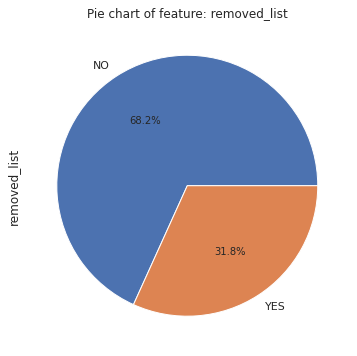

In [ ]:
data['removed_list'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature: removed_list')
plt.show()

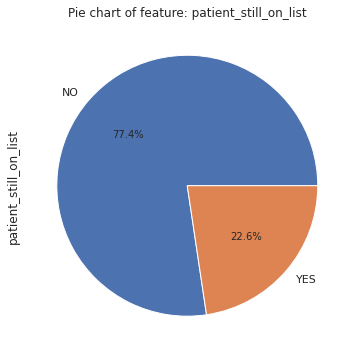

In [ ]:
data['patient_still_on_list'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature: patient_still_on_list')
plt.show()

- clearly, they are not similar. 
- let's check how similar they are.

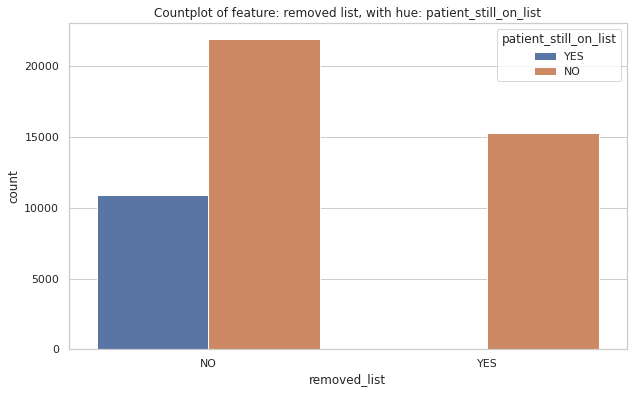

In [ ]:
sns.countplot(x=data['removed_list'],hue=data['patient_still_on_list'])
plt.title('Countplot of feature: removed list, with hue: patient_still_on_list')
plt.show()

- Clearly, 'removed_list' contains more information than 'patient_still_on_list' and subsumes all the information that 'patient_still_on_list' has in it.
- If 'removed_list'=YES, 'patient_still_on_list' cannot be 'NO'
- So, we will drop 'patient_still_on_list'

In [ ]:
to_be_removed.append('patient_still_on_list')

#### Checking features: Id

- We don't need a primary key for each patient in data analysis. The feature does not carry any value.
- It is redundant and should be removed

In [ ]:
to_be_removed.append('Id')

#### Checking features: HLA frequencies based on allele distribution in the population

- WE WANT TO MAKE OUR MODEL MORE UNIVERSAL BY REMOVING THE LOCAL ELEMENTS FROM IT.
- From the original study of Silva and Team, we know that, and we quotes: *"HLA frequency variables (A, B and DR) were calculated by dividing the number of times the allele of interest is observed in a population by the total number of copies of all the alleles at that genetic locus in the population. HLA frequency in the population of São Paulo state was obtained from the Allele Frequencies net database. To standardize HLA antigen assignments an HLA Dictionary was used. The serological equivalents were listed as expert assigned types."*
- Thus, the frequencies of various HLA antigens are dependent on the population of interest where the program of graft transplant is being held. The genetic (allele) variation in serology of HLA types of a population and thus their frequencies depend on various biological factors, and will differ from geographic region to other. 
- Since, we want to make a more universal study, we decide to remove the nine features associated with 'Calculated Frequencies" which are local.
- We will take HLA values as continuous variables and use them as predictor variables instead of their frequencies to make our prediction model more 'universal.'

In [ ]:
hla_frequencies= ['calculated_frequency_DR.f1', 'calculated_frequency_DR.f2','calculated_frequency_DR.f', 'calculated_frequency_B.f1',\
                  'calculated_frequency_B.f2','calculated_frequency_B.f','calculated_frequency_A.f1','calculated_frequency_A.f2',\
                  'calculated_frequency_A.f']
to_be_removed.extend(hla_frequencies)

#### Checking features: race

- We are going to remove it because it a local feature. 
- Transplants globally are affected by the Race of a patient because of socio-economic and genetic reasons, but every georgraphical space has its own set of races/castes. 
- As far as biological reasons are concerned, we already have their HLA values, which makes race as a purely local feature, and we are going to drop it for this reason.


In [ ]:
to_be_removed.append('race')

#### Checking features: subregion 
    

- We are going to drop this feature as well for its being totally local. 
- For example, in India, there is a huge disparity in transplants between North and South regions. For that we might create a new model specific to India or any othergeographical region of the world.
- Keeping this feature in our model will be redundant.

In [ ]:
to_be_removed.append('subregion')

#### Checking features: age_cat and age_at_list_registration


- let us see how our event of interest gets affected with age_cat. 
- Event of interest can be roughly considered as Transplant time if we do not want to go for Kaplan Meir plots
- Our events of interest are 'Time_Tx' and 'Transplant_Y_N'
- We draw barplot 

In [ ]:
data['age_cat'].value_counts()

18.a.60     34752
Maior.60    11775
Menor.18     1626
Name: age_cat, dtype: int64

Let's rename the feature values:
  - 18.a.60 as From18to60
  - Maior.60 as Over60
  - Menor.18 as Below18

In [ ]:
data['age_cat'].replace(to_replace= '18.a.60' , value= 'From18to60', inplace=True)
data['age_cat'].replace(to_replace= 'Maior.60' , value= 'Over60', inplace=True)
data['age_cat'].replace(to_replace= 'Menor.18' , value= 'Below18', inplace=True)

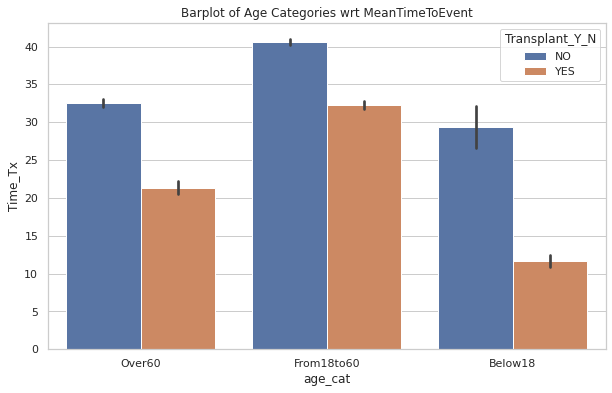

In [ ]:
#Barplot of Age Categories wrt MeanTimeToEvent

sns.barplot(data=data,x='age_cat', y='Time_Tx', hue='Transplant_Y_N')
plt.title('Barplot of Age Categories wrt MeanTimeToEvent')
plt.show()

- As is clear from the above graph, average waiting time of patients below 18 is lesser than those above them, which is a direct result of our allocation criteria.
- Also a patient has a very low chance of getting transplanted if they are above 60 years of age
- So, feature values is consistent, as we expected it. 
- Now, we don't really need age_at_list_registration' as age_cat contains the information contained in 'age_at_list_registration'.
- So we drop it.


In [ ]:
to_be_removed.append('age_at_list_registration')

#### Checking features: cPRA_cat and cPRA


- cPRA is one of the most important criteria chosen by doctors to select a patient for transplant
- Let us play close attention to it.

In [ ]:
data['cPRA_cat'].value_counts()

Zero           34205
Entre_0_50      7311
Maior_80        3895
Entre_50_80     2742
Name: cPRA_cat, dtype: int64

renaming the feature values:
  - Zero = Zero
  - Entre_0_50 = ZeroTo50
  - Entre_50_80 = From50To80
  - Maior_80 = Over80

In [ ]:
data['cPRA_cat'].replace(to_replace= 'Entre_0_50' , value= 'ZeroTo50', inplace=True)
data['cPRA_cat'].replace(to_replace= 'Entre_50_80' , value= 'From50To80', inplace=True)
data['cPRA_cat'].replace(to_replace= 'Maior_80' , value= 'Over80', inplace=True)

we already know how outcome features will play about with respect to cPRA_cat. But let us still explore various visuals, to know if the data is consistent and if we can find something interesting

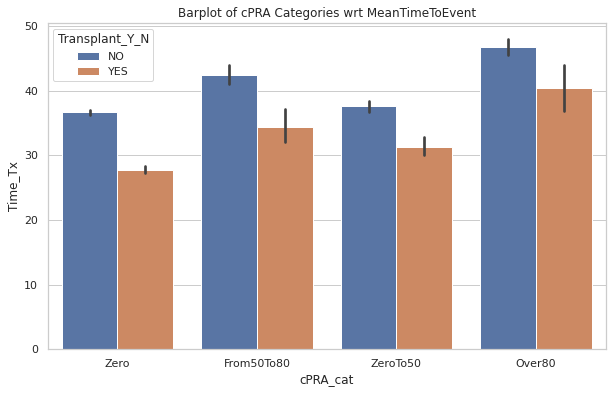

In [ ]:
#Barplot of cPRA Categories wrt MeanTimeToEvent

sns.barplot(data=data,x='cPRA_cat', y='Time_Tx', hue='Transplant_Y_N')
plt.title('Barplot of cPRA Categories wrt MeanTimeToEvent')
plt.show()

In [ ]:
to_be_removed.append('cPRA')

# FEATURE ENGINEERING

### Reducing Dimensionality by removing redundant features
- We pause in our analysis and remove the features as stored in to_be_removed list. And check how far we have gone. 
- We also save the dataset in its current state as data1. We will play with data1 in further analysis.


In [ ]:
data1 = data.drop(columns=to_be_removed)

- Let us now rename a few features to make analysis a little easier. The idea is to be more presentable

In [ ]:
data1.columns

Index(['date', 'age_cat', 'time_on_Dialysis', 'sex', 'underline_disease',
       'diabetes', 'Blood_type', 'number_transfusion', 'gestation',
       'prior_transplant', 'cPRA_cat', 'HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2',
       'HLA_DR1', 'HLA_DR2', 'DR_00', 'B_00', 'A_00', 'HBc_antibodies',
       'HCV_antibodies', 'death', 'Time_death', 'Transplant_Y_N', 'Time_Tx',
       'removed_list', 'event'],
      dtype='object')

### Renaming features for proper analysis

In [ ]:
data1.rename(columns = {'underline_disease':'underlying_disease','time_on_Dialysis':'dialysis_duration','Blood_type':'blood_gp','number_transfusion':'transfusions',\
                        'Time_Tx':'duration','Time_death':'time_death','Transplant_Y_N':'if_transplanted','sex':'gender','removed_list':'if_on_list'}, inplace=True)

# EDA & Feature Engineering Continued....

In [ ]:
#an empty list keeping a count of features to be dropped
to_be_dropped = []

#### Feature Analysis: 'dialysis_duration'

- The given values are in months. 
- We know from discussion with doctors that if the patient has gone through many dialysis sessions, he is given a little less priority than the one who is fresh.
- Let's check its distribution plot

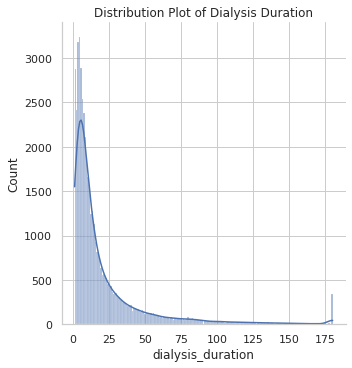

In [ ]:
sns.displot(x=data1['dialysis_duration'],kde=True) 
plt.title("Distribution Plot of Dialysis Duration")
plt.show()



```
# This is formatted as code
```

the data is highly right-skewed. So, we will go ahead with log-transformation.

In [ ]:
#log transformation of dialysis of duration
data1['dialysis_duration'] = np.log(data1['dialysis_duration'])

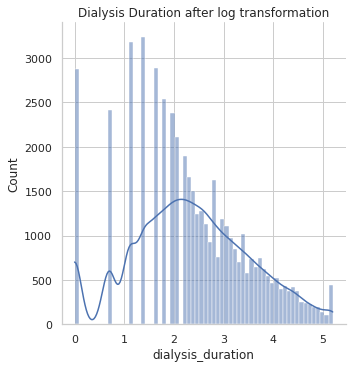

In [ ]:
sns.displot(x=data1['dialysis_duration'],kde=True) 
plt.title("Dialysis Duration after log transformation")
plt.show()

Let us check how outcome variables get affected with different values of dialysis duration

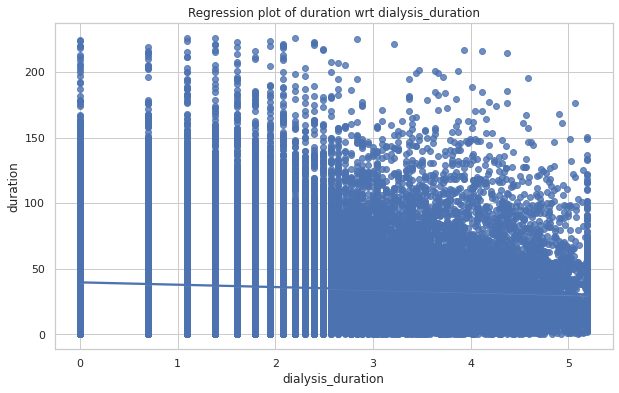

In [ ]:
sns.regplot(data=data1,x='dialysis_duration',y='duration')
plt.title("Regression plot of duration wrt dialysis_duration")
plt.show()

dialysis_duration seems to have ALMOST NO effect on 'duration' also. Just a little downward trend.

We can almost safely drop this feature. But we won't, for now.

#### Feature Analysis: transfusions

- It is the number of transfusions a patient gets subjects to. Clinically transfusions are a sporadic thing and do not affect transplant outcome. 
- It is not time dependent, like dialysis_duration is. We do not know when a patient might need a transfusion.
- Let us do some statiscal analysis and observe.

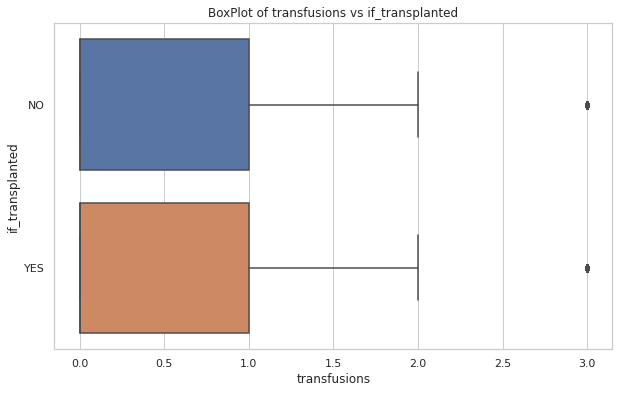

In [ ]:
#transfusions and if_transplanted
sns.boxplot(data=data1,x='transfusions',y='if_transplanted',orient='h')
plt.title("BoxPlot of transfusions vs if_transplanted")
plt.show()

- Almost the same spread and the same Median. 
- But let's check with Kruskal Wallis Test (as the distribution of data is not known)

In [ ]:
stats.kruskal(data1['transfusions'][data1['if_transplanted'] == 'YES'],\
               data1['transfusions'][data1['if_transplanted'] == 'NO'])

KruskalResult(statistic=0.9619207923862838, pvalue=0.3267034095459755)

- A very high value of p and low value of F statistic shows we cannot reject the null hypothesis that the median number of transfusions is same for both groups of if_transplanted- YES and NO. We don't have sufficient proof to claim that the different transfusions values lead to statistically significant difference in the outcome of if_transplanted.
- So our suspicion was correct. Thus, we can, in fact, do away with this feature.
- We don't have to worry about waiting time(duration) as its result is conditional on if_transplanted being YES. 


In [ ]:
to_be_dropped.append('transfusions')

#### Feature Analysis: gender

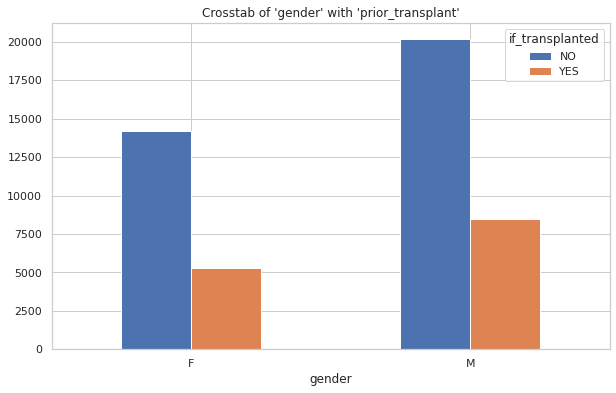

In [ ]:
ct = pd.crosstab(data1['gender'],data1['if_transplanted'])
ct.plot(kind="bar", stacked=False, rot=0, )
plt.title("Crosstab of 'gender' with 'prior_transplant'")
plt.show()

- mean counts of if_transplanted=NO and YES, are different for different groups of gender- M and F. 
- Let us make try to make a plausible conclusion with chi-2 test, with alpha=0.05

In [ ]:
c, p, dof, expected = chi2_contingency(ct)
print(p)

3.779194601761589e-09


- p-value<0.05; so, we can reject the null hypothesis that gender and if_transplanted are independent of each other
- Thus, if_transplanted has some dependency on gender, implying 'gender' is a feature of importance.

#### Feature Analysis: prior_transplant

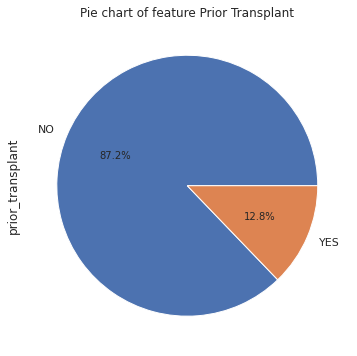

In [ ]:
data['prior_transplant'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature Prior Transplant')
plt.show()

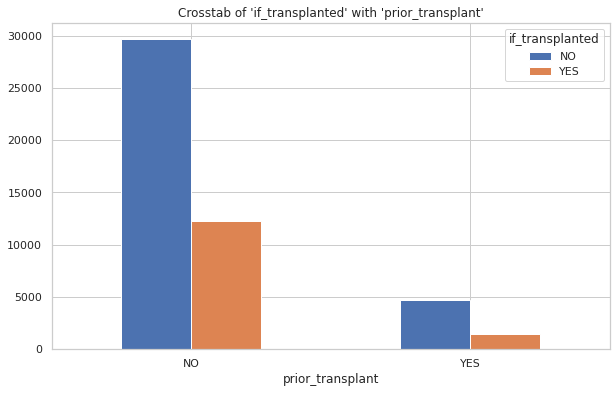

In [ ]:
ct = pd.crosstab(data1['prior_transplant'],data1['if_transplanted'])
ct.plot(kind="bar", stacked=False, rot=0, )
plt.title("Crosstab of 'if_transplanted' with 'prior_transplant'")
plt.show()

- mean counts of if_transplanted=NO and YES, are different for different groups of prior_transplant NO and YES.
-  Let us make try to make a plausible conclusion with chi-2 test, with alpha=0.05

In [ ]:
c, p, dof, expected = chi2_contingency(ct)
print(p)

2.9770539138795677e-19


- p-value<0.05; so, we can reject the null hypothesis that prior_transplant and if_transplanted are independent of each other
- Thus, if_transplanted has some dependency on prior_transplant, implying 'prior_transplant' is a feature of importance.

#### Feature Analysis: HCV_antibodies

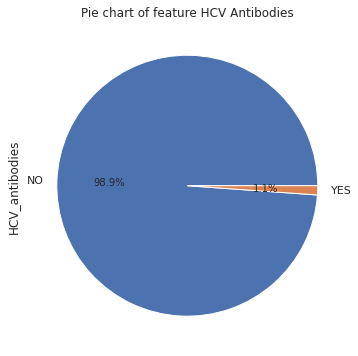

In [ ]:
data1['HCV_antibodies'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature HCV Antibodies')
plt.show()

Most of the values are NO. This feature is redundant. So we have to drop it.

> Indented block



In [ ]:
to_be_dropped.append('HCV_antibodies')

#### Feature Analysis: HBs_antibodies

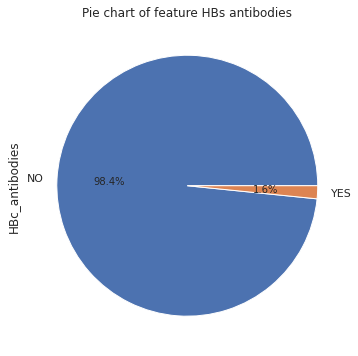

In [ ]:
data1['HBc_antibodies'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature HBs antibodies')
plt.show()

Most of the values are NO. This feature is redundant. So we have to drop it.


In [ ]:
to_be_dropped.append('HBc_antibodies')

#### Feature Analysis: A_00, B_00, DR_00

In [ ]:
data1['A_00'].value_counts()

heterozigoto    43171
homozigoto       4982
Name: A_00, dtype: int64

Let's rename the group names in their english version

In [ ]:
data1.replace(to_replace= 'homozigoto' , value= 'Homozygote', inplace=True)
data1.replace(to_replace= 'heterozigoto' , value= 'Heterozygote', inplace=True)

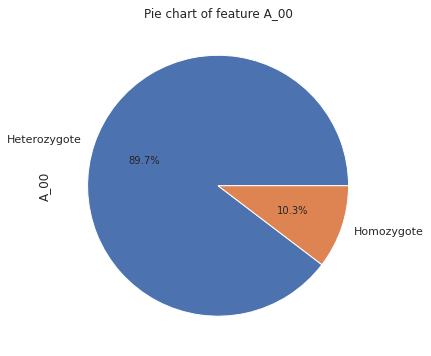

In [ ]:
data1['A_00'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature A_00')
plt.show()

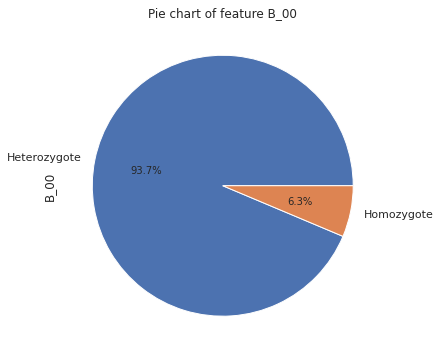

In [ ]:
data1['B_00'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature B_00')
plt.show()

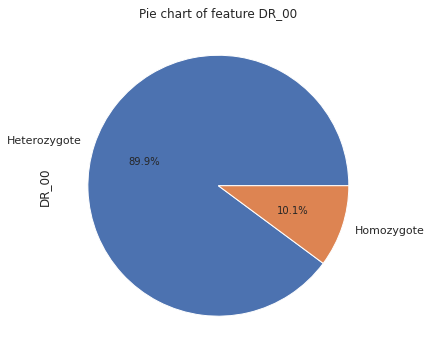

In [ ]:
data1['DR_00'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie chart of feature DR_00')
plt.show()

- The ratio of homozygote and heterozygote in all three: A_00,B_00, and DR_00 is statistically significant.
- We don't need to perform chi-2 test to check the significance of these features because like HLA types, these are not continuous features. They are biological features and each one has its importance in deciding the outcomes.

#### Feature Analysis: 'underlying_disease' and 'diabetes'

In [ ]:
data1['underlying_disease'].value_counts()

Outras          16626
HAS             13165
Diabetes         9987
GNC              7234
Pielonefrite     1141
Name: underlying_disease, dtype: int64

- Outras : others
- HAS : it is misspelled. It should be HUS (Hemolytic uremic syndrome)
- GNC : it is misspelled. It should be GNS (Glumerulo-Nephrotic Syndrome)
- Pielonefrite : Pylonephritis (PN)
- Diabetes has a count of 9987.

In [ ]:
data1.replace(to_replace= 'Outras' , value= 'others', inplace=True)
data1.replace(to_replace= 'HAS' , value= 'HUS', inplace=True)
data1.replace(to_replace= 'Diabetes' , value= 'diabetes', inplace=True)
data1.replace(to_replace= 'GNC' , value= 'GNS', inplace=True)
data1.replace(to_replace= 'Pielonefrite' , value= 'PN', inplace=True)

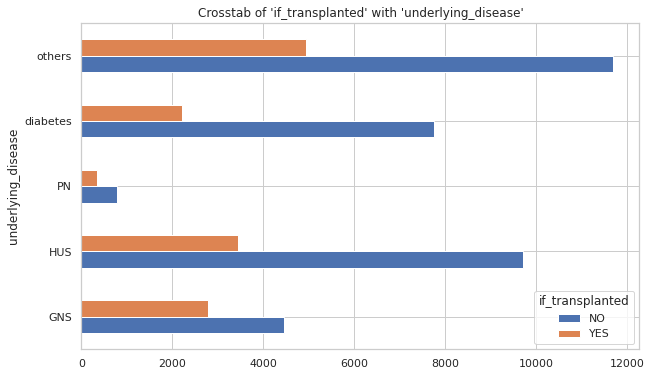

In [ ]:
ct = pd.crosstab(data1['underlying_disease'],data1['if_transplanted'])
ct.plot(kind="barh", stacked=False, rot=0, )
plt.title("Crosstab of 'if_transplanted' with 'underlying_disease'")
plt.show()

In [ ]:
c, p, dof, expected = chi2_contingency(ct)
print(p)

7.596234142186201e-126


- p-value<0.05; so, we can reject the null hypothesis that underlying_disease and if_transplanted are independent of each other
- Thus, if_transplanted has some dependency on underlying_disease, implying 'underlying_disease' is a feature of importance.

LET US CHECK 'diabetes' feature now.

In [ ]:
data1['diabetes'].value_counts()

1    38166
0     9987
Name: diabetes, dtype: int64

- As we noted 9987 is the number in 'underlying disease' as well. But here is encoded a little unusually, maybe because of some error on the researchers part. 1 should be non-diabetic and 0 should be diabetic.
- Anyhow, the most important thing is the information of diabetes is already contained in the feature 'underlying_disease', so we can drop the feature 'diabetes' without loss of information.

In [ ]:
to_be_dropped.append('diabetes')

#### Feature Analysis: 'date'

- date feature is redundant. There is already a column which contains the information of duration - one of the predictions. We have the data of each patient's stay in the study.
- We will drop 'date'

In [ ]:
to_be_dropped.append('date')

#### Feature Analysis: 'death','time_death','if_on_list', and 'event'

- 'death','time_death','if_on_list', and 'event' are outcomes we do not care about in our analysis.
- we are after each patient's tranplants journey, in the form of their waiting time, the outcome of their wait and the variables affecting the outcome.
- so, from the perspective of this study, we can drop features related to death, and other associated events as the feature 'event' imbibes into itself.

In [ ]:
#dropping 'death','time_death','if_on_list','event'
drop = ['death','time_death','if_on_list','event']
to_be_dropped.extend(drop)

# PAUSE

In [ ]:
# dropping the features

In [ ]:
data2 = data1.drop(columns=to_be_dropped)

In [ ]:
data1.columns

Index(['date', 'age_cat', 'dialysis_duration', 'gender', 'underlying_disease',
       'diabetes', 'blood_gp', 'transfusions', 'gestation', 'prior_transplant',
       'cPRA_cat', 'HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2', 'HLA_DR1',
       'HLA_DR2', 'DR_00', 'B_00', 'A_00', 'HBc_antibodies', 'HCV_antibodies',
       'death', 'time_death', 'if_transplanted', 'duration', 'if_on_list',
       'event'],
      dtype='object')

In [ ]:
data2.columns

Index(['age_cat', 'dialysis_duration', 'gender', 'underlying_disease',
       'blood_gp', 'gestation', 'prior_transplant', 'cPRA_cat', 'HLA_A1',
       'HLA_A2', 'HLA_B1', 'HLA_B2', 'HLA_DR1', 'HLA_DR2', 'DR_00', 'B_00',
       'A_00', 'if_transplanted', 'duration'],
      dtype='object')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#exporting the data into a new csv file to do preliminary EDA and increasing our understanding of the data
data2.to_csv('//content//drive//MyDrive//Transplant//data2.csv', index = False)

# A LOOK AT PREDICTIONS

- We are after
  - if_transplanted
  - duration
= First we check if the patient got transplanted, then we calculate their waiting time.

- So we have to depend to Time to Event methods popularly known as SURVIVAL ANALYSIS methods as explained earlier. 
- Let us continue with our Data exploration and Preparation, now even with Kaplan Meier plots.
- For that we need to Label Encode if_transplanted

In [ ]:
# label encoding 'if_transplanted'
le = LabelEncoder()
data2['if_transplanted'] = le.fit_transform(data2['if_transplanted'])

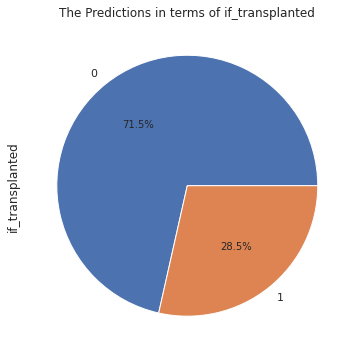

In [ ]:
# prediction variable
data2['if_transplanted'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('The Predictions in terms of if_transplanted')
plt.show()

- data is highly imbalanced in favor of 'NO'/0
- Most of the patients did not get transplanted, which is clinically expected

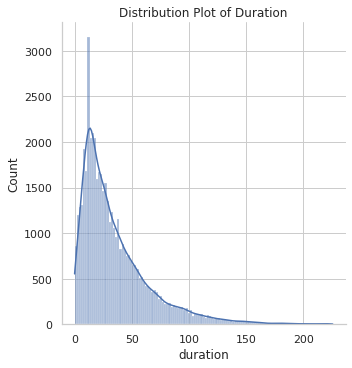

In [ ]:
sns.displot(x=data2['duration'],kde=True) 
plt.title("Distribution Plot of Duration")
plt.show()

Of those that get transplanted, a high number of them get transplanted within 12.5 months

# EDA WITH KAPLAN MEIER PLOTS

#### A General KM Plot

In [ ]:
kmf = KaplanMeierFitter()

In [ ]:
kmf.fit(durations = data2['duration'], event_observed = data2['if_transplanted'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 48153 total observations, 34421 right-censored observations>

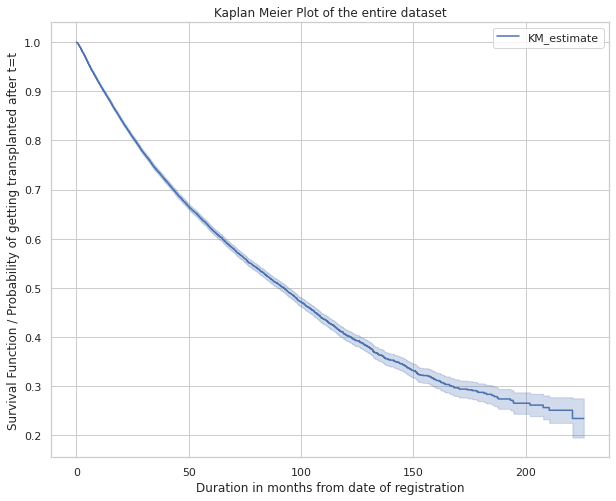

In [ ]:
kmf.plot_survival_function(figsize = (10,8))
plt.xlabel("Duration in months from date of registration")
plt.ylabel("Survival Function / Probability of getting transplanted after t=t")
plt.title("Kaplan Meier Plot of the entire dataset")
plt.show()

- the general suvival function plot as per KM estimate is as expected, it is exponential, but with a high degree of linearity.
- let us check the probability density curve (cummulative probability)

In [ ]:
kmf.median_survival_time_

92.3

In general, a person is expected get transplanted after 92.3 months.

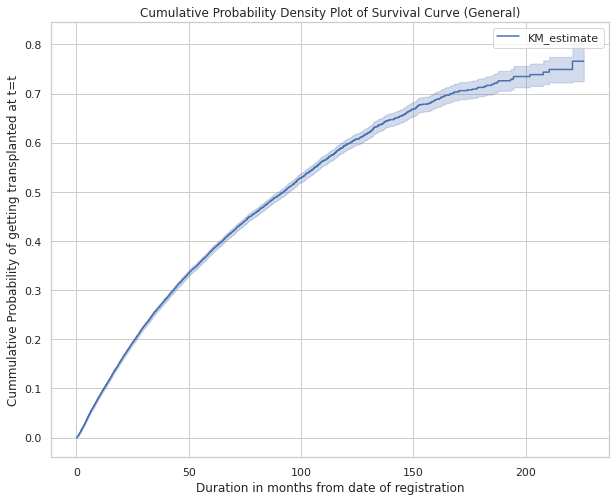

In [ ]:
kmf.plot_cumulative_density(figsize=(10,8))
plt.xlabel("Duration in months from date of registration")
plt.ylabel("Cummulative Probability of getting transplanted at t=t")
plt.title('Cumulative Probability Density Plot of Survival Curve (General)')
plt.show()

#### KM Plots with groups

- Hazard function is nothing but the slope of survival curve. One of the basic assumptions of CPH is that the hazard ratio (ratio of various hazards) should be constant over time. That is one of the things we are checking by plotting KM plots. 
- we plot cummulative density curves of survival functions with various features to understand how much variation is there in terms of group differences. 
- if there is too much difference, we may either take the different branches different features, or we may compress our period of study
- the idea is simple, the plots of various groups in a features should be approximately parallel to each other and not cut each other by a wide margin.
- We go feature by feature

#### Feature Analysis: blood_gp

- Blood group is one of the most selection criteria when it comes to selecting a patient for transplant. 
- But it's mostly a matter of luck, when it comes to cadaveric grafts. And yet, we can take for granted that the blood group availability depends on Population. 

In [ ]:
data2['blood_gp'].value_counts()

O     23640
A     16951
B      5834
AB     1728
Name: blood_gp, dtype: int64

- We already see that the dataset of blood groups is highly favoring the group values O and A. So our model is going to be affected by that. And yet, this is the data we have, and we have to accept it as it is.
- Let us see the impact of blood groups on 'if_transplanted' with chi-2 test


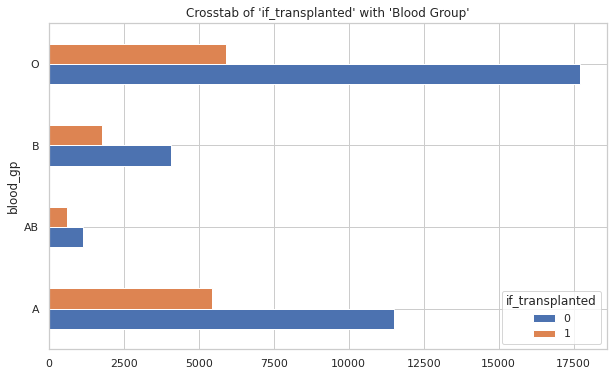

In [ ]:
ct = pd.crosstab(data2['blood_gp'],data2['if_transplanted'])
ct.plot(kind="barh", stacked=False, rot=0, )
plt.title("Crosstab of 'if_transplanted' with 'Blood Group'")
plt.show()

means vary depending on group

In [ ]:
c, p, dof, expected = chi2_contingency(ct)
print(p)

2.8334400233036852e-61


A p-value less than 0.05 and the graph clearly confirms that blood group of a patient has statistical impact on if_transplanted.

- Let us plot KM CDF curves for different blood groups

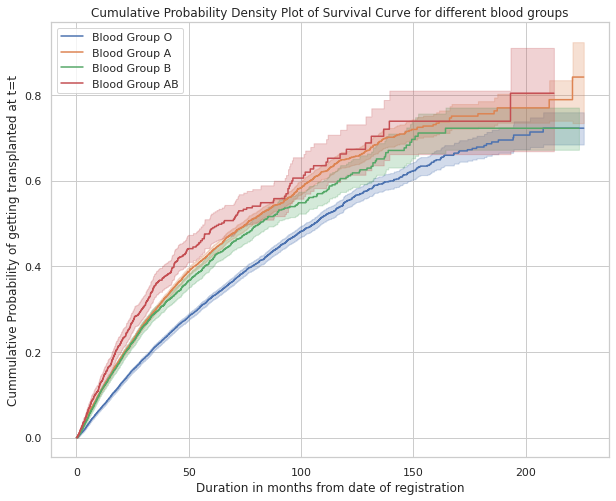

In [ ]:
fig,ax = plt.subplots()

kmf.fit(durations = data2[data2['blood_gp']=='O']['duration'],
        event_observed = data2[data2['blood_gp']=='O']['if_transplanted'],
        label='Blood Group O')
kmf.plot_cumulative_density(figsize=(10,8), ax = ax) #subplot of Blood Group O

kmf.fit(durations = data2[data2['blood_gp']=='A']['duration'],
        event_observed = data2[data2['blood_gp']=='A']['if_transplanted'],
        label='Blood Group A')
kmf.plot_cumulative_density(figsize=(10,8), ax = ax)

kmf.fit(durations = data2[data2['blood_gp']=='B']['duration'],
        event_observed = data2[data2['blood_gp']=='B']['if_transplanted'],
        label='Blood Group B')
kmf.plot_cumulative_density(figsize=(10,8), ax = ax)

kmf.fit(durations = data2[data2['blood_gp']=='AB']['duration'],
        event_observed = data2[data2['blood_gp']=='AB']['if_transplanted'],
        label='Blood Group AB')
kmf.plot_cumulative_density(figsize=(10,8), ax = ax)

plt.xlabel("Duration in months from date of registration")
plt.ylabel("Cummulative Probability of getting transplanted at t=t")
plt.title('Cumulative Probability Density Plot of Survival Curve for different blood groups')
plt.show()

- As expected, the probability of getting transplanted is generally on a higher level with blood grou AB, as it is a Universal Recipient.
- And the the same is lowest for O for all time points.
- For high values of t, the curves of different groups cross, but mostly they are parallel to each other. 
- So we can go ahead with CPH modelling

#### Feature Analysis: Underlying Disease

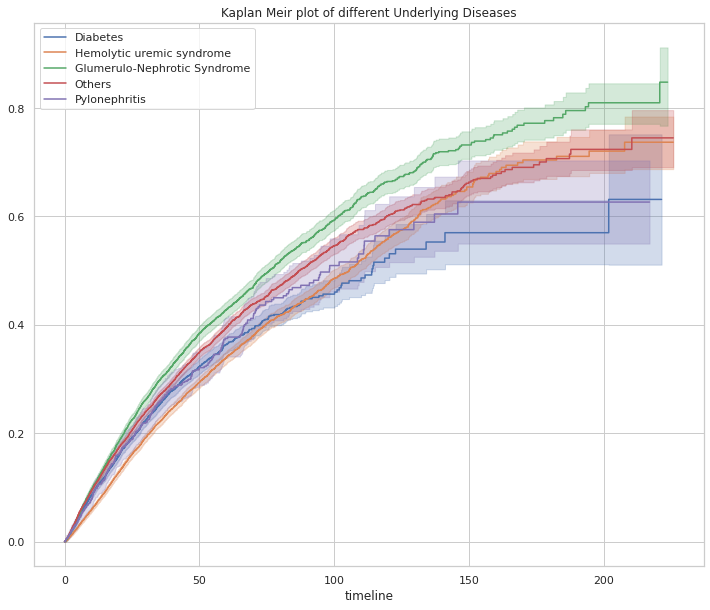

In [ ]:
fig, ax = plt.subplots()

kmf.fit(durations = data2[data2['underlying_disease']=='diabetes']['duration'],
        event_observed = data2[data2['underlying_disease']=='diabetes']['if_transplanted'],
        label='Diabetes')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

kmf.fit(durations = data2[data2['underlying_disease']=='HUS']['duration'],
        event_observed = data2[data2['underlying_disease']=='HUS']['if_transplanted'],
        label='Hemolytic uremic syndrome')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

kmf.fit(durations = data2[data2['underlying_disease']=='GNS']['duration'],
        event_observed = data2[data2['underlying_disease']=='GNS']['if_transplanted'],
        label='Glumerulo-Nephrotic Syndrome')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

kmf.fit(durations = data2[data2['underlying_disease']=='others']['duration'],
        event_observed = data2[data2['underlying_disease']=='others']['if_transplanted'],
        label='Others')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

kmf.fit(durations = data2[data2['underlying_disease']=='PN']['duration'],
        event_observed = data2[data2['underlying_disease']=='PN']['if_transplanted'],
        label='Pylonephritis')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

plt.title("Kaplan Meir plot of different Underlying Diseases")
plt.show()

- It is clear that the curves of various values of underlying_disease are intersecting each other. They do not have constant hazard ratios. So if we fit our dataset into CPH, we will encounter problems. (Hint: CPH assumes constant hazard ratios over time)
- So we can either think of dropping the feature, or better, we can convert it into different features like Others, Diabetes, Pylonephritis etc.
- That we will do in one-hot encoding.

#### Feature Analysis: gender

In [ ]:
data2['gender'].value_counts()

M    28684
F    19469
Name: gender, dtype: int64

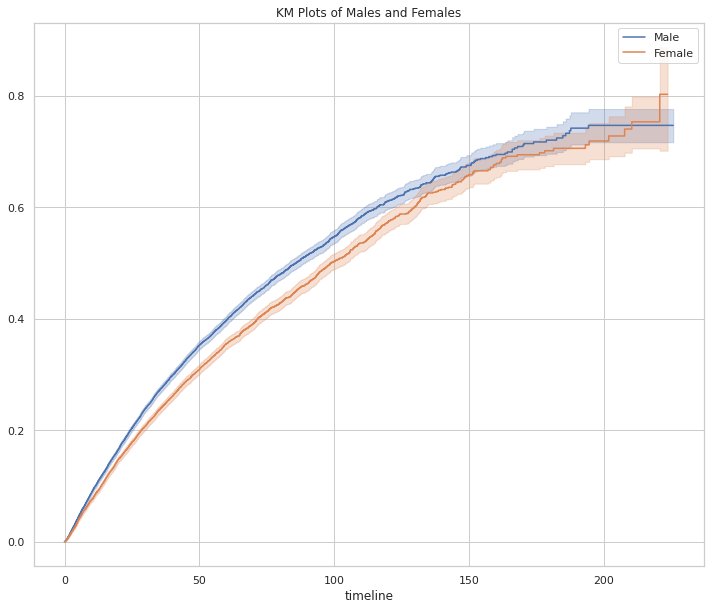

In [ ]:
figure, ax = plt.subplots()

kmf.fit(durations = data2[data2['gender']=='M']['duration'],
        event_observed = data2[data2['gender']=='M']['if_transplanted'],
        label='Male')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

kmf.fit(durations = data2[data2['gender']=='F']['duration'],
        event_observed = data2[data2['gender']=='F']['if_transplanted'],
        label='Female')
kmf.plot_cumulative_density(figsize=(12,10), ax = ax)

plt.title('KM Plots of Males and Females')
plt.show()

parallel and with almost constant slope except for bigger values of t. we can go ahead with CPH

- Almost all the values are NO. We have not dropped the column because of its clinical significance.
- So we expect KM plot to be biased towards NO.

# PAUSE

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age_cat             48153 non-null  object 
 1   dialysis_duration   48153 non-null  float64
 2   gender              48153 non-null  object 
 3   underlying_disease  48153 non-null  object 
 4   blood_gp            48153 non-null  object 
 5   gestation           48153 non-null  object 
 6   prior_transplant    48153 non-null  object 
 7   cPRA_cat            48153 non-null  object 
 8   HLA_A1              48153 non-null  int64  
 9   HLA_A2              48153 non-null  int64  
 10  HLA_B1              48153 non-null  int64  
 11  HLA_B2              48153 non-null  int64  
 12  HLA_DR1             48153 non-null  int64  
 13  HLA_DR2             48153 non-null  int64  
 14  DR_00               48153 non-null  object 
 15  B_00                48153 non-null  object 
 16  A_00

# ONE HOT ENCODING OF THE DATA

In [ ]:
#creating a list of features that need to be one-hot encoded
label_encode_list = ['gender','gestation','DR_00', 'B_00', 'A_00', 'prior_transplant']
one_hot_list = ['underlying_disease', 'blood_gp', 'age_cat','cPRA_cat']

In [ ]:
#one hot encoding
data3 = pd.get_dummies(data2,
               columns=one_hot_list,
               prefix=one_hot_list,
               drop_first=True)

In [ ]:
#label encoding
def label_encode(data, label_encode_list):
  for feature in label_encode_list:
    data[feature] = le.fit_transform(data[feature])

In [ ]:
label_encode(data3,label_encode_list)

# NORMALISATION/SCALING OF DATA

In [ ]:
scaler = MinMaxScaler(feature_range =(0, 1)) 
scaler.fit(data3)

MinMaxScaler()

In [ ]:
data4 = pd.DataFrame(scaler.transform(data3)) 
data4.columns = data3.columns

In [ ]:
data4.head()

,dialysis_duration,gender,gestation,prior_transplant,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,DR_00,B_00,A_00,if_transplanted,duration,underlying_disease_HUS,underlying_disease_PN,underlying_disease_diabetes,underlying_disease_others,blood_gp_AB,blood_gp_B,blood_gp_O,age_cat_From18to60,age_cat_Over60,cPRA_cat_Over80,cPRA_cat_Zero,cPRA_cat_ZeroTo50
0,0.00000,1.00000,0.00000,0.00000,0.01250,0.32500,0.53659,0.62195,0.18750,0.43750,0.00000,0.00000,0.00000,0.00000,0.05787,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000
1,0.26696,1.00000,0.00000,0.00000,0.01250,0.30000,0.21951,0.42683,0.68750,0.00000,1.00000,0.00000,0.00000,0.00000,0.30491,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
2,0.13348,1.00000,0.00000,0.00000,0.30000,0.31250,0.17073,0.21951,0.06250,0.93750,0.00000,0.00000,0.00000,0.00000,0.05388,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
3,0.54559,1.00000,0.00000,1.00000,0.30000,0.31250,0.17073,0.21951,0.06250,0.93750,0.00000,0.00000,0.00000,0.00000,0.05388,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000
4,0.81254,1.00000,0.00000,0.00000,0.30000,0.85000,0.17073,0.32927,0.81250,0.93750,0.00000,0.00000,0.00000,0.00000,0.02864,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000


# MODELLING

In [ ]:
coxph = CoxPHFitter()

In [ ]:
#creating a function which spurts out VIF values in the form of a dataframe

def vif(data):
  vif = pd.DataFrame() 
  vif["feature"] = data.drop(columns=['if_transplanted','duration'],inplace=False).columns
  length = len(vif["feature"]) 
  vif["VIF"] = [variance_inflation_factor(data.values, i) 
                          for i in range(length)] 
  return vif

In [ ]:
def heatmap(data):
  vif(data)
  fig,ax = plt.subplots(figsize=(30,30))
  sns.heatmap(round(data.corr().abs(),2),annot=True)
  plt.show()

In [ ]:
coxph.fit(data4,'duration', 'if_transplanted')
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 48153 total observations, 34421 right-censored observations>
             duration col = 'duration'
                event col = 'if_transplanted'
      baseline estimation = breslow
   number of observations = 48153
number of events observed = 13732
   partial log-likelihood = -134208.08
         time fit was run = 2022-07-04 12:14:54 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
dialysis_duration             0.37       1.45       0.04             0.29             0.45                 1.34                 1.57
gender                        0.10       1.11       0.02             0.05             0.15                 1.05                 1.16
gestation                     0.17       1.19       0.03             0.12             0.23                 1.12                 1.26
prior_transplant             -0.13       0.88       0.03            -0.19            -0.07                 0.83                 0.93
HLA_A1                       -0.36       0.70       0.06            -0.47            -0.25                 0.62                 0.78
HLA_A2                       -0.27       0.76       0.04            -0.34            -0.20                 0.71                 0.82
HLA_B1                       -0.34       0.71       0.05            -0.43            -0.25                 0.65                 0.78
HLA_B2                       -0.12       0.88       0.05            -0.22            -0.02                 0.80                 0.98
HLA_DR1                      -0.11       0.90       0.04            -0.18            -0.04                 0.84                 0.96
HLA_DR2                       0.10       1.10       0.04             0.03             0.17                 1.03                 1.19
DR_00                        -1.24       0.29       0.05            -1.33            -1.14                 0.26                 0.32
B_00                         -0.40       0.67       0.04            -0.49            -0.31                 0.61                 0.73
A_00                         -0.24       0.78       0.03            -0.31            -0.18                 0.74                 0.83
underlying_disease_HUS       -0.22       0.80       0.03            -0.27            -0.17                 0.76                 0.84
underlying_disease_PN        -0.18       0.83       0.06            -0.29            -0.07                 0.75                 0.93
underlying_disease_diabetes  -0.10       0.91       0.03            -0.15            -0.04                 0.86                 0.96
underlying_disease_others    -0.09       0.91       0.02            -0.14            -0.04                 0.87                 0.96
blood_gp_AB                   0.22       1.24       0.04             0.13             0.30                 1.14                 1.35
blood_gp_B                   -0.04       0.96       0.03            -0.09             0.01                 0.91                 1.01
blood_gp_O                   -0.38       0.69       0.02            -0.42            -0.34                 0.66                 0.71
age_cat_From18to60           -1.62       0.20       0.03            -1.69            -1.55                 0.19                 0.21
age_cat_Over60               -2.02       0.13       0.04            -2.10            -1.94                 0.12                 0.14
cPRA_cat_Over80              -0.97       0.38       0.06            -1.10            -0.84                 0.33                 0.43
cPRA_cat_Zero                 0.57       1.76       0.04             0.48             0.65                 1.62                 1.92
cPRA_cat_ZeroTo50             0.29       1.34       0.05             0.20             0.38                 1.22                 1.47

                          

In [ ]:
vif(data4)

In [ ]:
heatmap(data4)

# CONCLUSION(S)

- The Team read and understood a new statistical method that is highly used in the fields of Medicine and Time Series Forecasting. The project was as much about learning as it was about application of various concepts.
- A lot of time and effort went in the process of Data Engineering. The team had to almost reverse engineer in order to understand the various features in the dataset. It was a new learning curve.
- Every feature was paid close attention to one by one, and necessary steps taken as and when required. A decent score of c-index of 0.68 was achieved.
- By the end it was realized that creating a full-fledged prediction model would be too demanding given the time constraints, the complexity of the project and the limitations in the understanding of team members. 
- Inputs of the mentor helped the team in making sense of the data from an industrial perspective, and even though the scope of the project was narrowed a bit, the team considers the project a success.